# Table of Contents
* [Description](#Description)
* [Import Python Modules](#Import-Python-Modules)
* [Select Output Folder](#Select-Output-Folder)
* [Select Data, OBs and DFs](#Select-Data,-OBs-and-DFs)
	* [Data](#Data)
	* [OBs](#OBs)
	* [DFs](#DFs)
* [Display Data and Select ROI](#Display-Data-and-Select-ROI)
* [Normalize](#Normalize)


# Description

In this notebook, the user will have:

1. Select an output folder
2. to select a set of data to normalized, 
3. a set of OBs 
4. **optionally** a set of DFs. 
5. **optionally** Select a ROI on the data

**The notebook will take care of the rest**, will **normalized** and **export** the data into the output folder defined by the user


# Import Python Modules

In [2]:
verbose = False

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

import config_handler
import file_handler
import math_handler
import utilities
import gui_widgets

import custom_style; custom_style.style()

In [3]:
%gui qt

# Select Output Folder

In [16]:
root_folder = config_handler.load_config(key = 'root_folder', \
                                         default_value = '/Volumes/Buffalo/IPTS/IPTS-16413/raw/radiographs/')
output_folder = config_handler.load_config(key='output_folder',
                                          default_value = root_folder)
output_folder = gui_widgets.gui_dname(dir=output_folder, message='Select Output Folder ....')
if output_folder:
    config_handler.save_config(key='output_folder', value=output_folder)

# Select Data, OBs and DFs

## Data

In [4]:
list_files = gui_widgets.gui_fname(dir=root_folder, message="Select Images ...", ext="tiff")
if list_files:
    config_handler.save_config(key='root_folder', value=os.path.dirname(list_files[0]))

## OBs

In [6]:
ob_folder = config_handler.load_config(key = 'ob_folder', \
                                     default_value = root_folder)
list_ob_files = gui_widgets.gui_fname(dir=ob_folder, message="Select OBs ...", ext="tiff")
if list_ob_files:
    config_handler.save_config(key='ob_folder', value=os.path.dirname(list_ob_files[0]))

## DFs 

In [7]:
with_df_widget = widgets.RadioButtons(options=['Yes','No'],
                               description="DFs ?")
display(with_df_widget)

In [9]:
if with_df_widget.value == 'Yes':
    df_folder = config_handler.load_config(key = 'df_folder', \
                                         default_value = root_folder)
    list_df_files = gui_widgets.gui_fname(dir=ob_folder, message="Select DFs ...", ext="tiff")
    if list_df_files:
        config_handler.save_config(key='df_folder', value=os.path.dirname(list_df_files[0]))

# Display Data and Select ROI

[1350, 700, 2000, 1000]

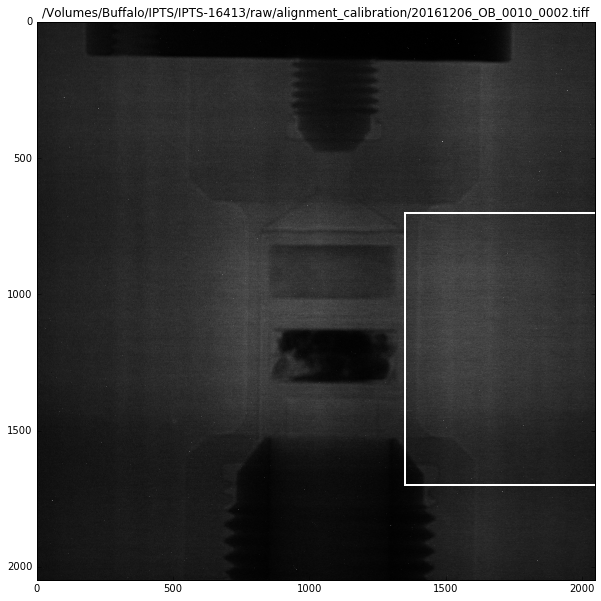

In [36]:
data_array = file_handler.read_tiff(list_files)
[height, width] = np.shape(data_array[0])
nbr_files = len(data_array)

def plot_images(file_index, x_left, y_top, width, height):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data_array[file_index],
                 cmap='gray')
    ax_img.set_title("{}".format(list_files[file_index]))
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [x_left, y_top, width, height]
    
preview = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=nbr_files-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=1350,
                                            description='X Left'),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=700,
                                           step=1,
                                           description='Y Top'),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=500,
                                           description="Width"),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=1000,
                                            description='Height'))

# Normalize and Export

In [41]:
[roi_x_left, roi_y_top, roi_width, roi_height] = preview.widget.result
if roi_x_left + roi_width >= width:
    roi_width = width - roi_x_left
if roi_y_top + roi_height >= height:
    roi_height = height - roi_y_top

# calculate mean OB
ob_array = file_handler.read_tiff(list_ob_files)
mean_ob = math_handler.mean_algo(ob_array)

# calculate mean DF (if any)
mean_df = []
if with_df_widget.value == 'Yes':
    df_array = file_handler.read_tiff(list_df_files)
    mean_df = math_handler.mean_algo(df_array)

# normalization
normalized_data = []
for _data in data_array:
    _mean_counts_data_roi = np.mean(_data[roi_y_top:roi_y_top+roi_height, roi_x_left:roi_x_left+roi_width])
    _mean_counts_ob_roi = np.mean(mean_ob[roi_y_top:roi_y_top+roi_height, roi_x_left:roi_x_left+roi_width])
    _coeff = _mean_counts_data_roi / _mean_counts_ob_roi
    
    if not isinstance(mean_df, np.ndarray):
        _result = (_data/mean_ob) / (_coeff)
    else:
        _num = _data - mean_df
        _den = mean_ob - mean_df
        _result = (_num/_den) / (_coeff)
    
    normalized_data.append(_result)
    
# export
for _index, _file in enumerate(list_files):
    _base_file = os.path.basename(_file)
    [_base, _ext] = os.path.splitext(_base_file)
    new_base_file_name = _base + '_normalized' + _ext
    new_full_name = os.path.join(output_folder, new_base_file_name)
    file_handler.write_tiff(filename=new_full_name, data=normalized_data[_index])

/Users/j35/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning:

divide by zero encountered in true_divide

/Users/j35/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning:

invalid value encountered in true_divide

